In [1]:
# ====== Packages =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from prettytable import PrettyTable
from tqdm import tqdm


# ---- data manipulators ----
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample

# ---- algorithms ----
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# ---- evaluation ------
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, RocCurveDisplay, roc_curve, precision_recall_curve

# ---- user defined modules ----
import pre_proccessing_helpers as hel
import models_helpers as mh


# This line makes matplotlib plot the figures inside the norebook
%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10

In [13]:
dataset = pd.read_pickle('data_for_tree.pkl')
dataset = dataset.reset_index()
dataset_hot_encoded = pd.get_dummies(dataset, columns=['test_indication'])
columns_names = [column for column in dataset_hot_encoded.columns]
columns_names.remove('corona_result')
columns_names.append('corona_result')

dataset_hot_encoded = dataset_hot_encoded.reindex(columns=columns_names)
dataset_hot_encoded

,index,test_week,cough,fever,sore_throat,shortness_of_breath,head_ache,test_indication_0,test_indication_1,test_indication_2,corona_result
0,0,18,0,0,0,0,0,1,0,0,0
1,1,18,1,0,0,0,0,1,0,0,0
2,2,18,0,1,0,0,0,1,0,0,0
3,3,18,1,0,0,0,0,1,0,0,0
4,4,18,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
274697,278842,11,0,0,0,0,0,1,0,0,0
274698,278843,11,0,0,0,0,0,1,0,0,0
274699,278844,11,0,0,0,0,0,1,0,0,0
274700,278845,11,0,0,0,0,0,0,1,0,1


In [14]:
X_train_raw, y_train_raw, X_test, y_test = mh.data_split(dataset_hot_encoded ,n_splits=1, test_size=0.4, train_size=0.6)
X_train, y_train = mh.up_down_sampling(X_train_raw, y_train_raw, ratio=1, up=True)

data_test = pd.concat([X_test, y_test], axis=1)
X_test, y_test, X_val, y_val = mh.data_split(data_test ,n_splits=1, test_size=0.5, train_size=0.5)


In [15]:
y_train.value_counts()

0    156005
1    156005
Name: corona_result, dtype: int64

/home/nirlalum/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.55777
[1]	validation_0-aucpr:0.55815
[2]	validation_0-aucpr:0.56405
[3]	validation_0-aucpr:0.56893
[4]	validation_0-aucpr:0.57223
[5]	validation_0-aucpr:0.57454
[6]	validation_0-aucpr:0.57458
[7]	validation_0-aucpr:0.57688
[8]	validation_0-aucpr:0.57845
[9]	validation_0-aucpr:0.57958
[10]	validation_0-aucpr:0.58131
[11]	validation_0-aucpr:0.58112
[12]	validation_0-aucpr:0.58272
[13]	validation_0-aucpr:0.58382
[14]	validation_0-aucpr:0.58482
[15]	validation_0-aucpr:0.58572
[16]	validation_0-aucpr:0.61335
[17]	validation_0-aucpr:0.64358
[18]	validation_0-aucpr:0.64569
[19]	validation_0-aucpr:0.64990
[20]	validation_0-aucpr:0.65264
[21]	validation_0-aucpr:0.65359
[22]	validation_0-aucpr:0.65477
[23]	validation_0-aucpr:0.65544
[24]	validation_0-aucpr:0.65689
[25]	validation_0-aucpr:0.65930
[26]	validation_0-aucpr:0.66194
[27]	validation_0-aucpr:0.66361
[28]	validation_0-aucpr:0.67013
[29]	validation_0-aucpr:0.67084
[30]	validation_0-aucpr:0.67202
[31]	validation_0-

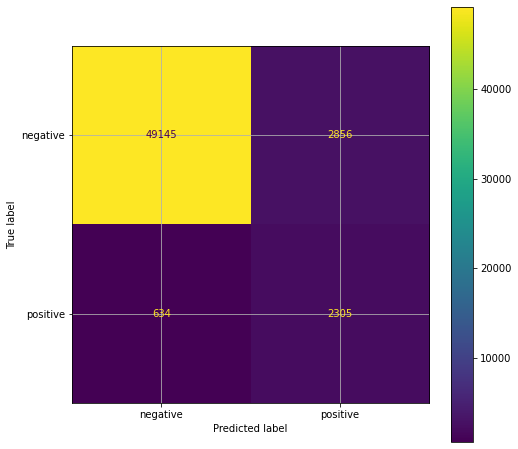

In [16]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', eta=0.1, max_depth=6, reg_lambda=100)
clf_xgb.fit(X_train, y_train,verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_val, y_val)])
xgb_pred = clf_xgb.predict(X_test)

mh.model_evaluation(y_test, xgb_pred)

In [16]:
params = {
           'max_depth': [3, 4, 5],
           'learning_rate': [0.1, 0.01, 0.05],
           'gamma': [0, 0.25, 1.0],
           'reg_lambda': [0, 1.0, 10.0],
           'scale_pos_weight': [1, 3, 5]
         }

optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic',subsample=0.9, use_label_encoder=False),
                              param_grid=params,
                              scoring='roc_auc',
                              verbose=10,
                              n_jobs=10,
                              cv=3
                             )


In [17]:
#optimal_params.fit(X_train, y_train,verbose=0, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_val, y_val)])

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV 3/3; 1/243] START gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1
[CV 1/3; 1/243] START gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1
[CV 2/3; 1/243] START gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1
[CV 2/3; 2/243] START gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3
[CV 1/3; 2/243] START gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3
[CV 3/3; 1/243] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1;, score=0.908 total time= 1.5min
[CV 1/3; 1/243] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1;, score=0.905 total time= 1.5min
[CV 2/3; 4/243] START gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1
[CV 3/3; 4/243] START gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=1
[CV 1/3

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=0.9, tree_m

In [18]:
optimal_params.best_params_

{'gamma': 1.0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'reg_lambda': 0,
 'scale_pos_weight': 3}

/home/nirlalum/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-aucpr:0.65028
[1]	validation_0-aucpr:0.64231
[2]	validation_0-aucpr:0.64953
[3]	validation_0-aucpr:0.64751
[4]	validation_0-aucpr:0.65462
[5]	validation_0-aucpr:0.65508
[6]	validation_0-aucpr:0.65625
[7]	validation_0-aucpr:0.66228
[8]	validation_0-aucpr:0.65522
[9]	validation_0-aucpr:0.66572
[10]	validation_0-aucpr:0.67088
[11]	validation_0-aucpr:0.67119
[12]	validation_0-aucpr:0.67045
[13]	validation_0-aucpr:0.67089
[14]	validation_0-aucpr:0.67024
[15]	validation_0-aucpr:0.67311
[16]	validation_0-aucpr:0.67742
[17]	validation_0-aucpr:0.67870
[18]	validation_0-aucpr:0.67937
[19]	validation_0-aucpr:0.68050
[20]	validation_0-aucpr:0.68238
[21]	validation_0-aucpr:0.68366
[22]	validation_0-aucpr:0.68415
[23]	validation_0-aucpr:0.68474
[24]	validation_0-aucpr:0.68559
[25]	validation_0-aucpr:0.68661
[26]	validation_0-aucpr:0.68692
[27]	validation_0-aucpr:0.68727
[28]	validation_0-aucpr:0.68858
[29]	validation_0-aucpr:0.68926
[30]	validation_0-aucpr:0.69022
[31]	validation_0-

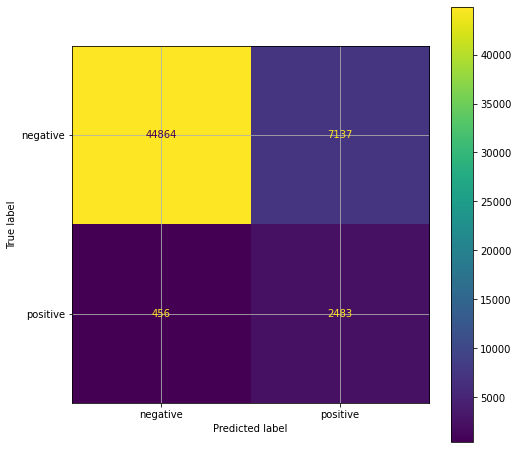

In [17]:
xgb_post_val = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.1, max_depth=6, reg_lambda=0, gamma=1.0, scale_pos_weight=3)
xgb_post_val.fit(X_train, y_train,verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_val, y_val)])
xgb_post_val_pred = xgb_post_val.predict(X_test)

mh.model_evaluation(y_test, xgb_post_val_pred)

# Check the missclassified examples:

# false negative examples:

In [24]:
X_test_no_dummies = dataset.iloc[y_test.index] # so we will have the not encoded test indication feature

y_test_aux = y_test.reset_index()
X_test_aux = X_test_no_dummies.reset_index()

negative_indexes = xgb_post_val_pred == 0
negative_pred_exm = y_test_aux.iloc[negative_indexes]
negative_pred_exm.drop(columns=['index'],inplace=True)
false_neg_pred = X_test_no_dummies.iloc[negative_pred_exm[negative_pred_exm['corona_result']==1].index]

/home/nirlalum/.local/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [25]:
false_neg_pred.head()

,index,test_week,cough,fever,sore_throat,shortness_of_breath,head_ache,test_indication,corona_result
151933,154276,15,0,0,0,0,0,0,1
6669,6711,18,0,0,0,0,0,0,1
57636,58257,17,0,0,0,0,0,0,1
32940,33194,17,0,0,0,0,0,2,1
163966,166376,15,0,0,0,0,0,0,1


In [22]:
hel.check_values_count(false_neg_pred)

the different values for index:
 154276    1
17563     1
111266    1
137180    1
86438     1
         ..
82999     1
169612    1
215257    1
26916     1
4058      1
Name: index, Length: 456, dtype: int64 

the different values for test_week:
 16    104
17     98
14     89
15     69
18     43
13     33
12     14
11      6
Name: test_week, dtype: int64 

the different values for cough:
 0    426
1     30
Name: cough, dtype: int64 

the different values for fever:
 0    442
1     14
Name: fever, dtype: int64 

the different values for sore_throat:
 0    455
1      1
Name: sore_throat, dtype: int64 

the different values for shortness_of_breath:
 0    452
1      4
Name: shortness_of_breath, dtype: int64 

the different values for head_ache:
 0    456
Name: head_ache, dtype: int64 

the different values for test_indication:
 0    440
2     14
1      2
Name: test_indication, dtype: int64 

the different values for corona_result:
 1    456
Name: corona_result, dtype: int64 



100%|██████████| 6/6 [00:00<00:00, 57.53it/s]


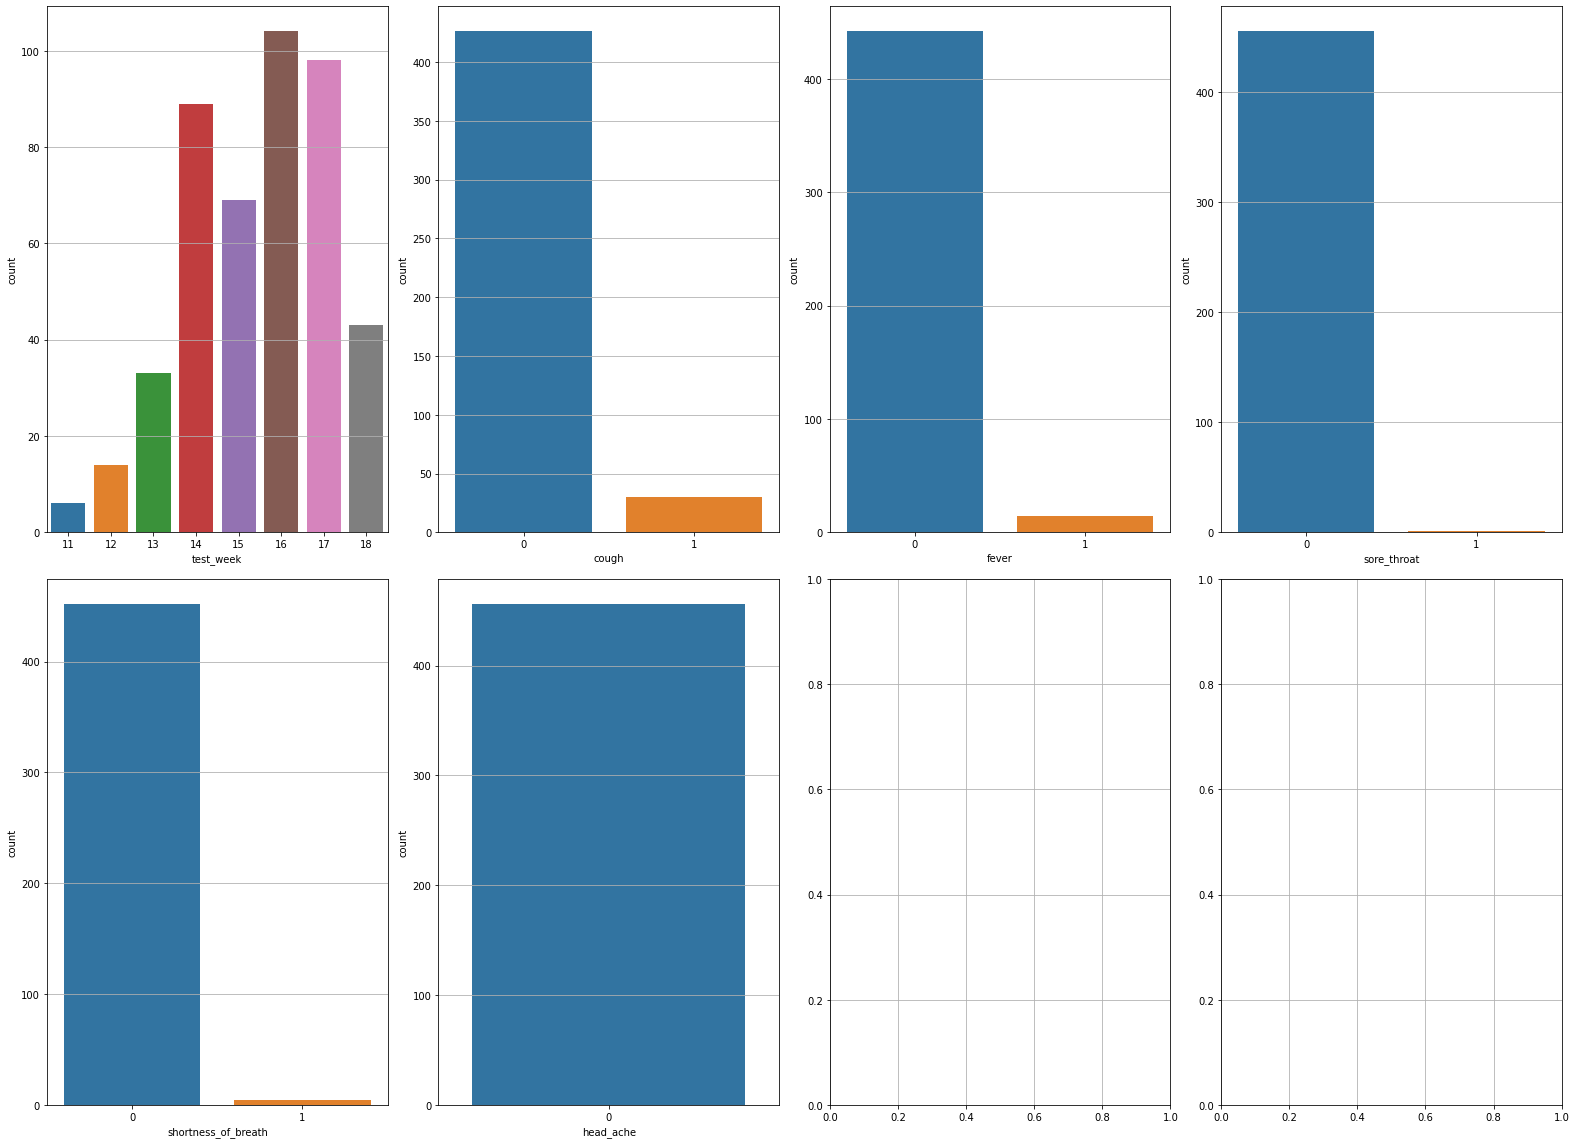

In [26]:
hel.plot_dataset(false_neg_pred[false_neg_pred.columns[1:7]], sns.countplot, 'countplot')

* It seems that most of the false negative are people without sympthoms. its makes sense that the model will infere that people with no sympthoms are not sick.
* The problem with corona that many people who are sick have no sympthoms at all and I think that in this area AI models are prone to fail.

## False positive examples:

In [29]:
X_test_no_dummies = dataset.iloc[y_test.index] # so we will have the not encoded test indication feature

y_test_aux = y_test.reset_index()
X_test_aux = X_test_no_dummies.reset_index()

positive_indexes = xgb_post_val_pred == 1
positive_pred_exm = y_test_aux.iloc[positive_indexes]

positive_pred_exm.drop(columns=['index'],inplace=True)
false_positive_pred = X_test_no_dummies.iloc[positive_pred_exm[positive_pred_exm['corona_result']==0].index]

/home/nirlalum/.local/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [32]:
len(false_positive_pred)

7137

100%|██████████| 6/6 [00:00<00:00, 65.49it/s]


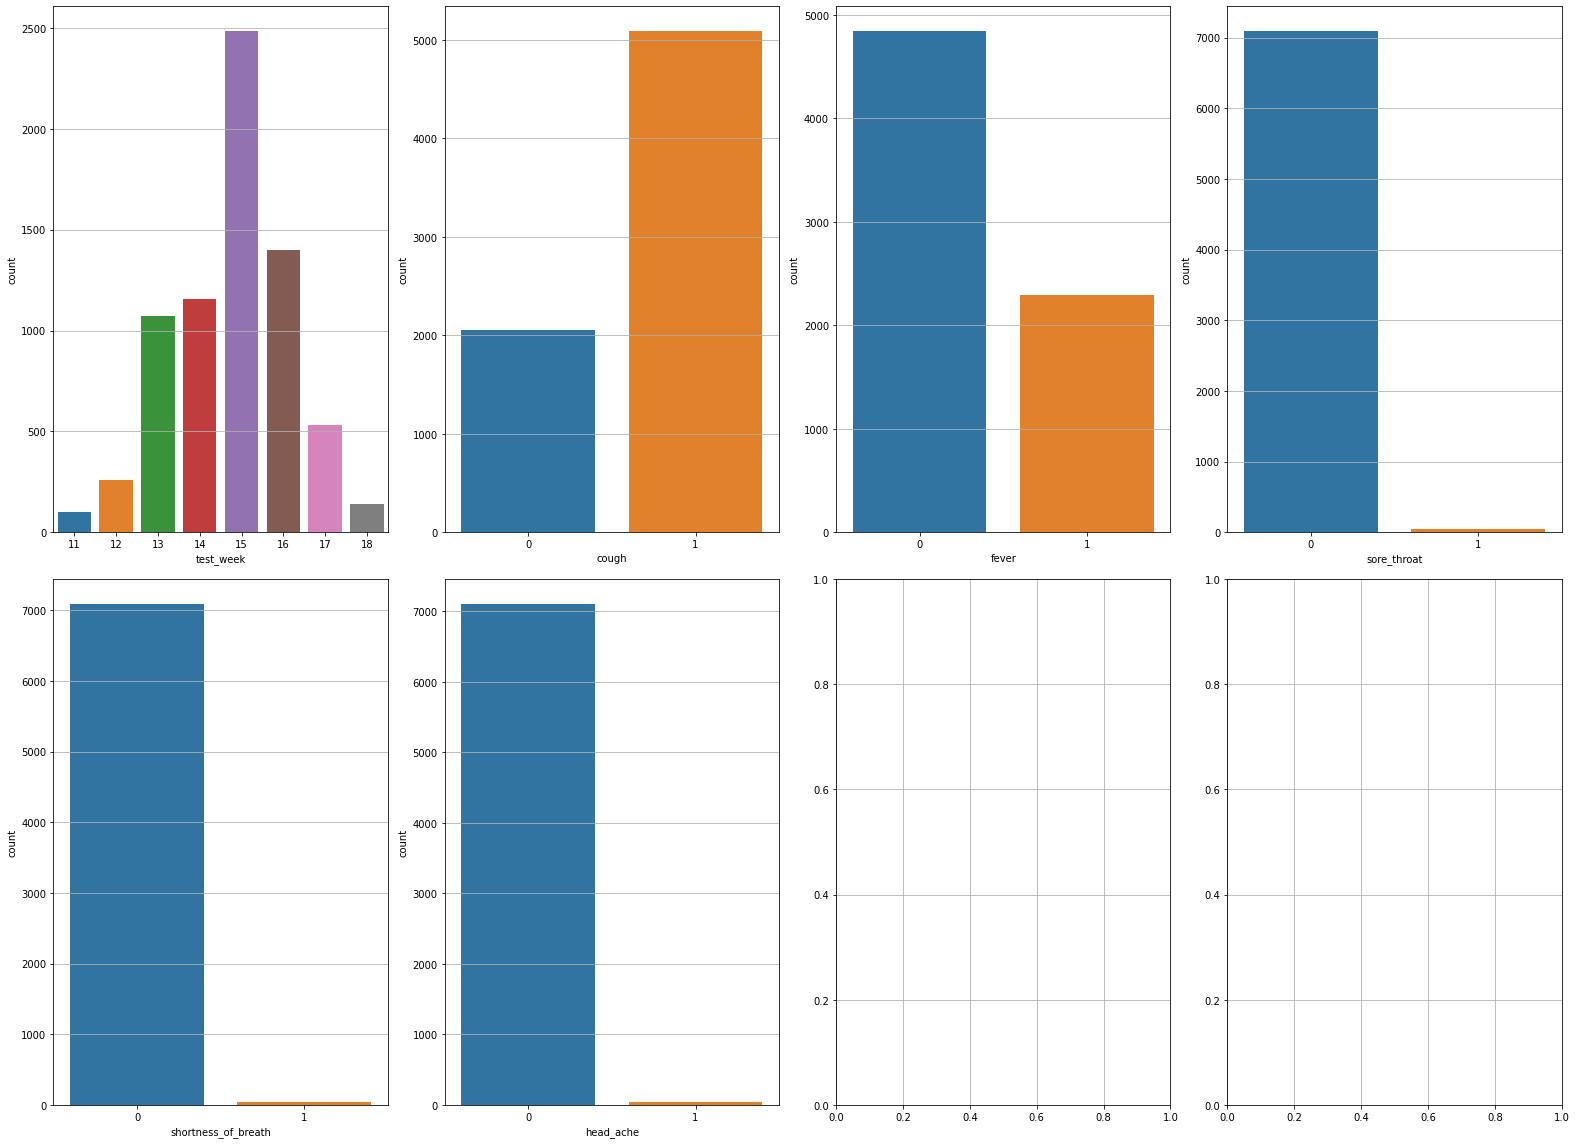

In [34]:
hel.plot_dataset(false_positive_pred[false_positive_pred.columns[1:7]], sns.countplot, 'countplot')